In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib
import shap
import time
import seaborn

import sys
sys.path.insert(1, r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning')

import FunctionCollection as fc
fc = importlib.reload(fc)
import os
import sqlite3
import torch
import captum.attr as c
from tqdm import tqdm

In [2]:
path = r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning'

run_name = 'OscNext_Angle_m27'

args = {'N_edge_feats': 6,
        'N_dom_feats': 7,
        'N_targets': 2,
        'N_outputs': 3,
        'N_metalayers': 2,
        'N_hcs': 64,
        'diagonal_cov': True,
        'wandb_activated': False,
        'type': 'Spherical_NLLH',
        'zenith': True,
        'id': '23ge',#wandb.util.generate_id()[:4],
        'eps': 1e-5,
        'output_offset': [3.14,1.57],
        'lr': 0.0209,
        'filename': 'dev_lvl7_mu_nu_e_classification_v003_unscaled.db',#dev_level7_mu_e_tau_oscweight_000.db #rasmus_classification_muon_3neutrino_3mio.db #dev_level7_oscNext_IC86_003.db
        'features': 'width, rqe, charge_log10, dom_time, dom_x, dom_y, dom_z',
        'targets': 'azimuth, zenith, energy_log10',
        'TrTV': (0,1,1)
       }

In [3]:
filepath = os.path.join(path,'raw_data')

centers = pd.DataFrame({'charge_log10': [-0.033858],
                        'dom_time': [10700.0],
                        'dom_x': [0],
                        'dom_y': [0],
                        'dom_z': [0],
                        'width': [4.5],
                        'rqe': [1.175]})
scalers = pd.DataFrame({'charge_log10': [0.274158],
                        'dom_time': [2699.0],
                        'dom_x': [300],
                        'dom_y': [300],
                        'dom_z': [300],
                        'width': [3.5],
                        'rqe': [0.175]})

centers = centers[args['features'].split(', ')].values
scalers = scalers[args['features'].split(', ')].values

def x_transform(df):
    df = (df - centers)/scalers
    return torch.tensor(df.values)

def y_transform(df):
    return torch.tensor(df.values)

dataset = fc.custom_db_dataset(filepath = filepath,
                               filename = args['filename'],
                               features = args['features'],
                               targets = args['targets'],
                               TrTV = args['TrTV'],
                               x_transform = x_transform,
                               y_transform = y_transform,
                               shuffle = False)

In [4]:
device = torch.device('cuda')

import Model_Loaders.Model_27 as M
M = importlib.reload(M)

Net = M.Load_model(args['type'],args)
model = Net.load_from_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')
model.eval();
model.to(device);

if features = x, Charge should be at x[:,-5], time at x[:,-4] and pos at x[:,-3:]
Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [5]:
test = dataset[5192].to(device)

N_background = 5000
background = dataset.collate(dataset[np.random.choice(dataset.__len__(),N_background).tolist()]).to(device)

ids, counts = background.batch.unique(return_counts=True)
sample = torch.cat([background.x[background.batch == i].unsqueeze(0) for i in ids[(counts == 15)]],dim=0)

if ((test.x == sample).sum(1).sum(1) == 15*7).sum() == 0:
    print("The test sample is included in the background sample!!!!!")

In [8]:
deep_e = shap.DeepExplainer(model, [t for t in sample])
deeplift_e = c.DeepLiftShap(model, multiply_by_inputs=True)
FA_e = c.FeatureAblation(model)
shapsampling_e = c.ShapleyValueSampling(model)

In [9]:
deep_vals = deep_e.shap_values([test.x])
deeplift_vals = deeplift_e.attribute(test.x.unsqueeze(0),baselines=sample,target=0,return_convergence_delta=False)

Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished


In [36]:
FA_vals = FA_e.attribute(test.x.unsqueeze(0))
shapsampling_vals1 = shapsampling_e.attribute(test.x.unsqueeze(0),
                                             baselines=torch.cat([background.x.mean(0).unsqueeze(0) for _ in range(test.x.shape[0])],dim=0).unsqueeze(0),
                                             target=0,
                                             n_samples=200,
                                             perturbations_per_eval=int(5e5))
shapsampling_vals2 = shapsampling_e.attribute(test.x.unsqueeze(0),
                                             baselines=0,
                                             target=0,
                                             n_samples=200,
                                             perturbations_per_eval=int(5e5))

In [96]:
shapsampling_vals3 = shapsampling_e.attribute(test.x.unsqueeze(0),
                                             baselines=torch.cat([background.x.mean(0).unsqueeze(0) for _ in range(test.x.shape[0])],dim=0).unsqueeze(0),
                                             target=0,
                                             n_samples=1000,
                                             perturbations_per_eval=int(5e5))
shapsampling_vals4 = shapsampling_e.attribute(test.x.unsqueeze(0),
                                             baselines=0,
                                             target=0,
                                             n_samples=1000,
                                             perturbations_per_eval=int(5e5))

In [102]:
shapsampling_vals5 = shapsampling_e.attribute(test.x.unsqueeze(0),
                                             baselines=sample.mean(0).unsqueeze(0),
                                             target=0,
                                             n_samples=1000,
                                             perturbations_per_eval=int(5e5))

In [113]:
deep_e2 = shap.DeepExplainer(model, [background.x[background.batch == i] for i in background.batch.unique()])
deep_vals2 = deep_e2.shap_values([test.x])

In [94]:
def plot_shapvals(shapvals):
    fig, ax = plt.subplots(figsize=(10,2))
#     im = ax.pcolor(shapvals.T,cmap='plasma')
    im = ax.pcolor(*np.mgrid[shapvals.shape[0]+0.5:-0.5:-1,shapvals.shape[1]+0.5:-0.5:-1],shapvals,cmap='plasma')
    
    plt.yticks(np.arange(1,shapvals.shape[1]+1),args['features'].split(', '))
    plt.xticks(np.arange(1,shapvals.shape[0]+1))
    
    fig.colorbar(im)
    fig.tight_layout()

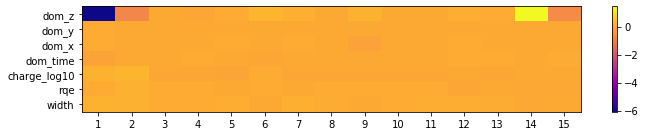

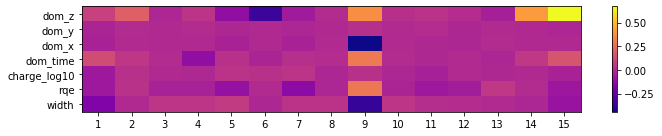

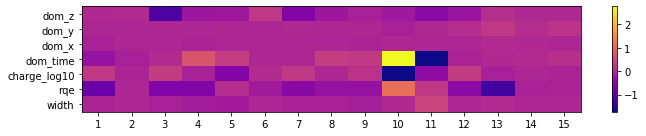

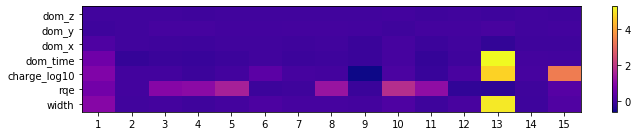

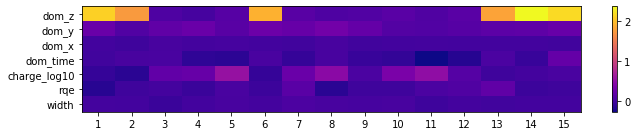

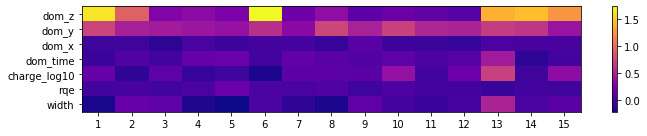

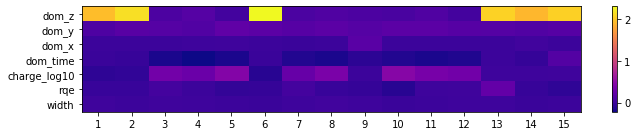

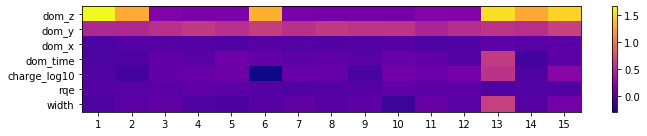

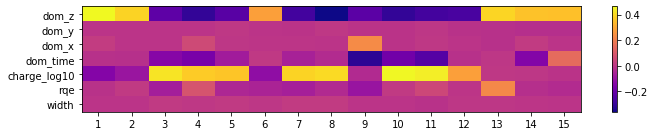

In [114]:
for vals in [deep_vals[0][0],
             deep_vals2[0][0],
             deeplift_vals.detach().cpu().squeeze(),
             FA_vals[0].detach().cpu().squeeze(),
             shapsampling_vals1.detach().cpu().squeeze(),
             shapsampling_vals2.detach().cpu().squeeze(),
             shapsampling_vals3.detach().cpu().squeeze(),
             shapsampling_vals4.detach().cpu().squeeze(),
             shapsampling_vals5.detach().cpu().squeeze()]:
    plot_shapvals(vals)

In [115]:
sample_vals = shapsampling_e.attribute(sample,
                                       baselines=0,
                                       target=0,
                                       n_samples=1000,
                                       perturbations_per_eval=int(5e5))

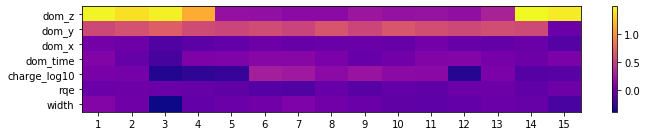

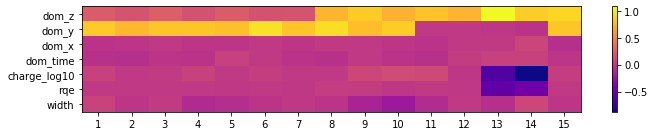

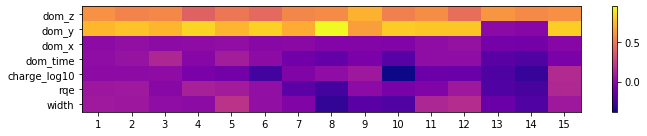

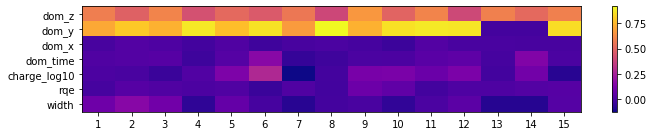

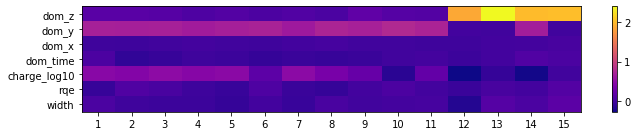

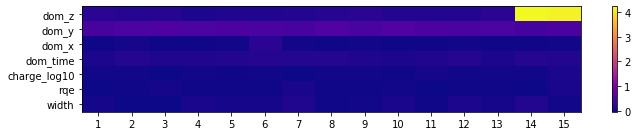

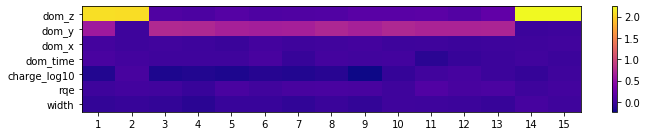

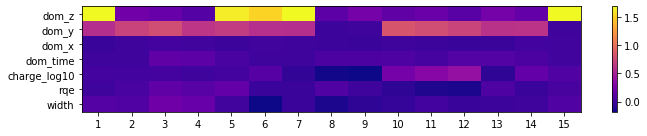

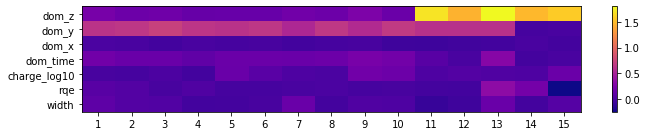

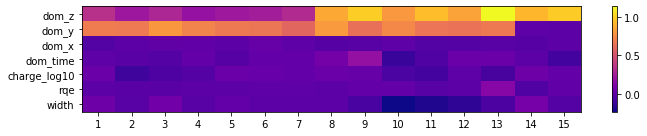

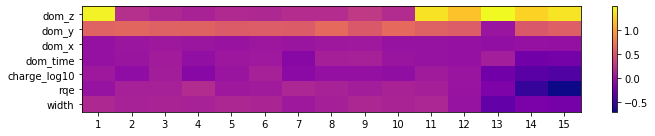

In [120]:
i = 0
for i, vals in enumerate(sample_vals):
    plot_shapvals(vals.detach().cpu())
    if i >= 10:
        break

In [126]:
saliency_e = c.Saliency(model)
saliency_vals = saliency_e.attribute(sample,0)

In [165]:
background.y.view(-1,3).shape

torch.Size([4999, 3])

In [167]:
counts

torch.Size([4999])

In [195]:

output

tensor([[ 3.3839,  3.1688,  2.9933],
        [ 1.6905,  0.9062,  3.9122],
        [ 2.0979,  0.9614,  2.4517],
        [ 6.1275,  1.1011,  2.8946],
        [ 7.7215,  2.5657,  3.5899],
        [ 6.1539,  2.5263,  1.6084],
        [ 3.2640,  1.1464,  5.1738],
        [ 6.4198,  0.6023,  5.0295],
        [ 7.5259,  2.9833,  4.6247],
        [ 4.1201,  2.6870,  5.0637],
        [ 3.2620,  2.4301,  3.2586],
        [ 5.4616,  2.3326,  2.4264],
        [ 5.7531,  1.8137,  3.5526],
        [ 5.3476,  0.2279,  3.6911],
        [ 3.5530,  2.4300,  5.4013],
        [ 3.7111,  1.4617,  3.1757],
        [ 2.3946,  0.1560,  3.2653],
        [ 2.2718,  0.8255,  0.6367],
        [ 3.6911,  0.2350,  2.9887],
        [ 2.4603,  2.4289,  2.2762],
        [ 2.8295,  0.0992,  3.1283],
        [ 3.2615,  0.5386,  5.5468],
        [ 2.4657,  0.2787,  1.7592],
        [ 3.8992,  2.7985,  4.1061],
        [ 7.2048,  2.4550,  2.4317],
        [ 4.3855,  2.5408,  1.8186],
        [ 4.1128,  0.6152,  3.4312],
 

In [196]:
# torch.save(torch.cat([sample.unsqueeze(1).detach().cpu(),
#                       sample_vals.unsqueeze(1).detach().cpu(),
#                       saliency_vals.unsqueeze(1).detach().cpu()],dim=1),
#            'samples/az_TrueShapSaliency_dom15_N248.pt')


output = model(sample).cpu()
output = torch.cat([output[:,[0,1]]+ torch.tensor(args['output_offset']), torch.square(output[:,[2]])+args['eps']],dim=1)

torch.save(torch.cat([background.y.view(-1,3)[counts==15].unsqueeze(1).detach().cpu(),
                      output.unsqueeze(1).detach().cpu()],dim=1),
           'samples/TruthPred_dom15_N248.pt')

In [197]:
t = torch.load("samples/az_TrueShapSaliency_dom15_N248.pt")
t2 = torch.load("samples/TruthPred_dom15_N248.pt")

<IPython.core.display.Javascript object>


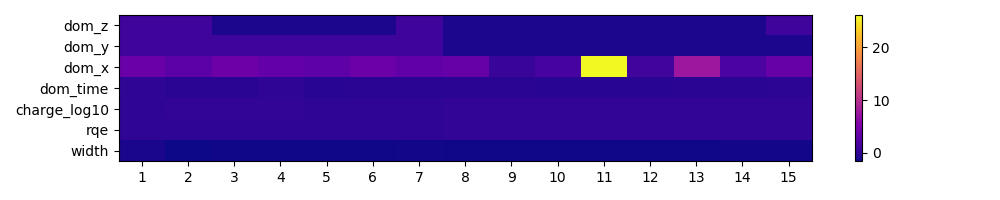

<IPython.core.display.Javascript object>


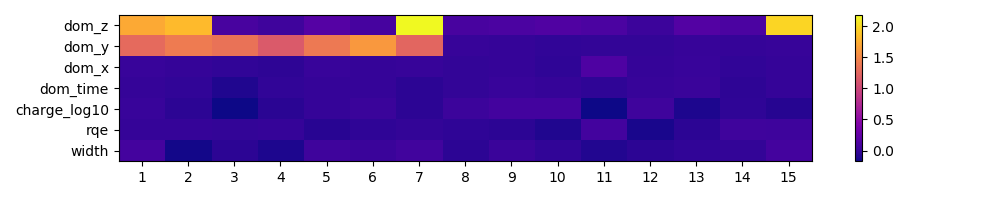

<IPython.core.display.Javascript object>


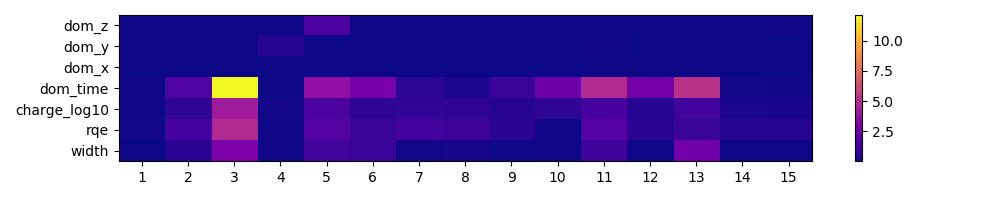

In [198]:
i = 30

plot_shapvals(t[i,0])
plot_shapvals(t[i,1])
plot_shapvals(t[i,2])

In [206]:
import time
global_row = None
curr_time = time.time()
def onclick(event):
    global curr_time
    global global_row
    row = int(event.xdata + 0.5)
    global_row = row
#     ax.set_title(row)
    if time.time() - curr_time > 0.1:
        curr_time = time.time()
        ax.set_title(time.time())
        index_line.set_xdata([row,row])
        fig.canvas.draw()
        try:
            selected.set_data(tmp[row,-3],tmp[row,-2])
            selected.set_3d_properties(tmp[row,-1])
            fig2.canvas.draw()
        except:
            pass

<IPython.core.display.Javascript object>


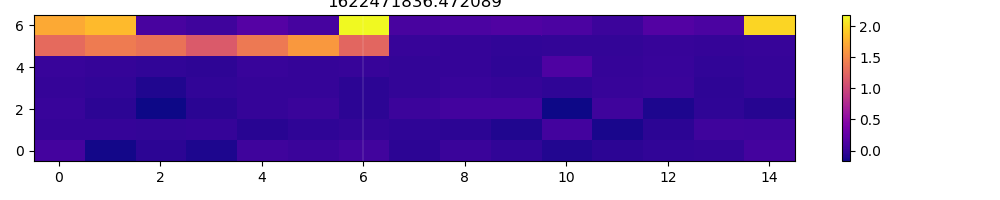

<IPython.core.display.Javascript object>


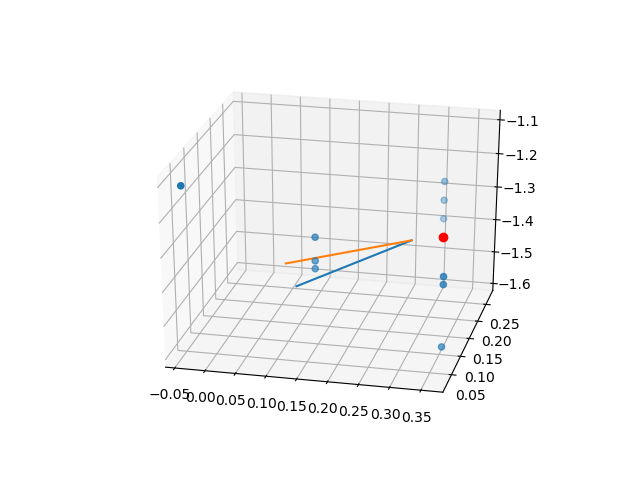

In [208]:
fig, ax = plt.subplots(figsize=(10,2))
# ax.imshow(shap_values[0][0].T)
im = ax.pcolor(*np.mgrid[14.5:-1.5:-1,6.5:-1.5:-1],t[i,1],cmap='plasma')
index_line, = ax.plot([5,5],[-0.5,6.5],'w',alpha=0.1)
fig.colorbar(im)
fig.tight_layout()
# fig.canvas.mpl_connect('motion_notify_event',onclick)
fig.canvas.mpl_connect('button_press_event',onclick)

tmp = t[i,0].clone()

CoC = (tmp[:,-3:]*tmp[:,-5].unsqueeze(1)).sum(0)/tmp[:,-5].sum()

def angle_to_vec(az,ze,scale=0.2):
    x = np.sin(ze)*np.cos(az)
    y = np.sin(ze)*np.sin(az)
    z = np.cos(ze)
    return scale*np.array([[0,x],[0,y],[0,z]]) + CoC.unsqueeze(1).numpy()

fig2 = plt.figure()
ax2 = fig2.add_subplot(111,projection='3d')

ax2.scatter(tmp[:,-3],tmp[:,-2],tmp[:,-1])
ax2.plot(*angle_to_vec(t2[i,0,0].item(),t2[i,0,1].item()))
ax2.plot(*angle_to_vec(t2[i,1,0].item(),t2[i,1,1].item()))
selected, = ax2.plot(*CoC.reshape(3,-1).numpy(),marker='o',color='r',zorder=10)

In [179]:
%matplotlib notebook